In [1]:
import numpy as np
import pandas as pd
import glob
import errno
import os
import random
import spacy
import string
import pickle as pkl
from collections import Counter

import torch
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [5]:
test_targets = ([1]*12500) + ([0]*12500)
train_split = 10000
train_targets = ([1]*train_split) + ([0]*train_split)
val_targets = ([1]*2500) + ([0]*2500)

In [6]:
# save index 0 for pad and 1 for unk
PAD_IDX = 0
UNK_IDX = 1

max_vocab_size = 20000
MAX_SENTENCE_LENGTH = 400

learning_rate = 0.001
emb_dim = 400

### bag of 1gram

In [52]:
train_1gram = pkl.load(open("train_data_tokens.p", "rb"))
all_train_1gram = pkl.load(open("all_train_tokens.p", "rb"))

val_1gram = pkl.load(open("val_data_tokens.p", "rb"))
test_1gram = pkl.load(open("test_data_tokens.p", "rb"))

In [53]:
token2id, id2token = build_vocab(all_train_1gram)

train_data_indices = token2index_dataset(train_1gram)
val_data_indices = token2index_dataset(val_1gram)
test_data_indices = token2index_dataset(test_1gram)

In [64]:
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

model = BagOfWords(len(id2token), emb_dim)

num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [65]:
val_acc_1 = []
train_acc_1 = []

print('Bag of 1gram')
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 625 iterations
        if i > 0 and i % 624 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
            train_acc_1.append(train_acc)
            val_acc_1.append(val_acc)

Bag of 1gram
Epoch: [1/5], Step: [625/625], Train loss: 0.3451674282550812, Train acc: 87.25, Validation Acc: 84.66
Epoch: [2/5], Step: [625/625], Train loss: 0.21920698881149292, Train acc: 91.89, Validation Acc: 87.5
Epoch: [3/5], Step: [625/625], Train loss: 0.1932273656129837, Train acc: 94.48, Validation Acc: 88.68
Epoch: [4/5], Step: [625/625], Train loss: 0.20265191793441772, Train acc: 96.27, Validation Acc: 88.92
Epoch: [5/5], Step: [625/625], Train loss: 0.08680014312267303, Train acc: 97.325, Validation Acc: 89.12


### bag of 2gram

In [7]:
train_2gram = pkl.load(open("train_2gram.p", "rb"))
all_train_2gram = pkl.load(open("all_train_2gram.p", "rb"))

val_2gram = pkl.load(open("val_2gram.p", "rb"))
test_2gram = pkl.load(open("test_2gram.p", "rb"))

In [8]:
token2id, id2token = build_vocab(all_train_2gram)

train_data_indices = token2index_dataset(train_2gram)
val_data_indices = token2index_dataset(val_2gram)
test_data_indices = token2index_dataset(test_2gram)

In [9]:
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

model = BagOfWords(len(id2token), emb_dim)

num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [10]:
val_acc_2 = []
train_acc_2 = []

print('Bag of 2gram')
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 625 iterations
        if i > 0 and i % 624 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
            train_acc_2.append(train_acc)
            val_acc_2.append(val_acc)

Bag of 2gram
Epoch: [1/5], Step: [625/625], Train loss: 0.43263113498687744, Train acc: 86.21, Validation Acc: 84.04
Epoch: [2/5], Step: [625/625], Train loss: 0.34586137533187866, Train acc: 91.07, Validation Acc: 87.5
Epoch: [3/5], Step: [625/625], Train loss: 0.15717627108097076, Train acc: 93.75, Validation Acc: 88.64
Epoch: [4/5], Step: [625/625], Train loss: 0.23986974358558655, Train acc: 95.455, Validation Acc: 88.9
Epoch: [5/5], Step: [625/625], Train loss: 0.1428360641002655, Train acc: 96.775, Validation Acc: 89.28


### bag of 3gram

In [11]:
train_3gram = pkl.load(open("train_3gram.p", "rb"))
all_train_3gram = pkl.load(open("all_train_3gram.p", "rb"))

val_3gram = pkl.load(open("val_3gram.p", "rb"))
test_3gram = pkl.load(open("test_3gram.p", "rb"))

In [12]:
token2id, id2token = build_vocab(all_train_3gram)

train_data_indices = token2index_dataset(train_3gram)
val_data_indices = token2index_dataset(val_3gram)
test_data_indices = token2index_dataset(test_3gram)

In [13]:
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

model = BagOfWords(len(id2token), emb_dim)

num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [14]:
val_acc_3 = []
train_acc_3 = []

print('Bag of 3gram')
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 625 iterations
        if i > 0 and i % 624 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
            train_acc_3.append(train_acc)
            val_acc_3.append(val_acc)

Bag of 3gram
Epoch: [1/5], Step: [625/625], Train loss: 0.46599072217941284, Train acc: 84.375, Validation Acc: 82.36
Epoch: [2/5], Step: [625/625], Train loss: 0.3396364152431488, Train acc: 89.95, Validation Acc: 86.5
Epoch: [3/5], Step: [625/625], Train loss: 0.21502694487571716, Train acc: 91.545, Validation Acc: 87.52
Epoch: [4/5], Step: [625/625], Train loss: 0.1919134110212326, Train acc: 93.935, Validation Acc: 88.06
Epoch: [5/5], Step: [625/625], Train loss: 0.06938639283180237, Train acc: 95.765, Validation Acc: 89.0


### bag of 4gram

In [15]:
train_4gram = pkl.load(open("train_4gram.p", "rb"))
all_train_4gram = pkl.load(open("all_train_4gram.p", "rb"))

val_4gram = pkl.load(open("val_4gram.p", "rb"))
test_4gram = pkl.load(open("test_4gram.p", "rb"))

In [16]:
token2id, id2token = build_vocab(all_train_4gram)

train_data_indices = token2index_dataset(train_4gram)
val_data_indices = token2index_dataset(val_4gram)
test_data_indices = token2index_dataset(test_4gram)

In [17]:
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

model = BagOfWords(len(id2token), emb_dim)

num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [18]:
val_acc_4 = []
train_acc_4 = []

print('Bag of 4gram')
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 625 iterations
        if i > 0 and i % 624 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Train acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss, train_acc, val_acc))
            train_acc_4.append(train_acc)
            val_acc_4.append(val_acc)

Bag of 4gram
Epoch: [1/5], Step: [625/625], Train loss: 0.5216785073280334, Train acc: 84.465, Validation Acc: 82.12
Epoch: [2/5], Step: [625/625], Train loss: 0.30953943729400635, Train acc: 89.245, Validation Acc: 85.92
Epoch: [3/5], Step: [625/625], Train loss: 0.2114473283290863, Train acc: 92.49, Validation Acc: 87.66
Epoch: [4/5], Step: [625/625], Train loss: 0.18493503332138062, Train acc: 94.185, Validation Acc: 88.34
Epoch: [5/5], Step: [625/625], Train loss: 0.1975054144859314, Train acc: 94.995, Validation Acc: 88.04


## Plot accuracy

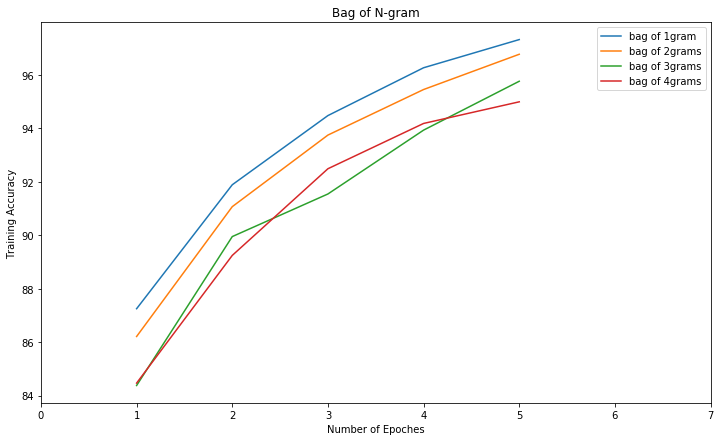

In [67]:
fig = plt.figure(1,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,6))

plt.plot(x_rge,train_acc_1,label="bag of 1gram")
plt.plot(x_rge,train_acc_2,label="bag of 2grams")
plt.plot(x_rge,train_acc_3,label="bag of 3grams")
plt.plot(x_rge,train_acc_4,label="bag of 4grams")

plt.xlim(0,7)
plt.legend(loc=1)
plt.xlabel("Number of Epoches")
plt.ylabel("Training Accuracy")
plt.title("Bag of N-gram")
plt.show()

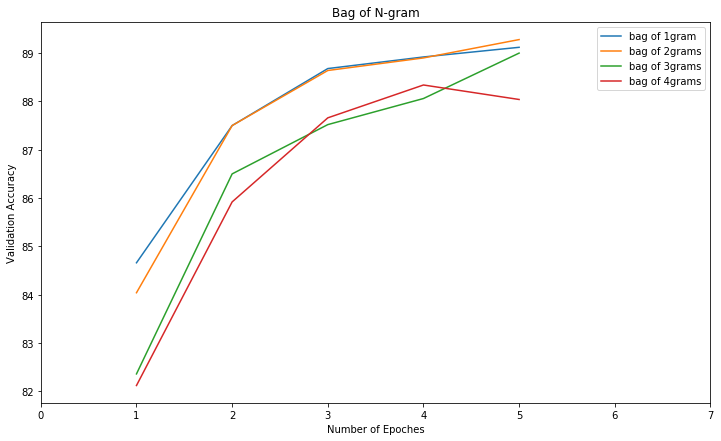

In [66]:
fig = plt.figure(2,figsize = (12,7)) 
ax = plt.subplot(111)
x_rge = list(range(1,6))

plt.plot(x_rge,val_acc_1,label="bag of 1gram")
plt.plot(x_rge,val_acc_2,label="bag of 2grams")
plt.plot(x_rge,val_acc_3,label="bag of 3grams")
plt.plot(x_rge,val_acc_4,label="bag of 4grams")

plt.xlim(0,7)
plt.legend(loc=1)
plt.xlabel("Number of Epoches")
plt.ylabel("Validation Accuracy")
plt.title("Bag of N-gram")
plt.show()